In [1]:
import sys,os
import time, datetime
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib import cm

from glob import glob
from scipy.interpolate import interp1d

## Set up global plot options

In [2]:
## Set up matplotlib options for plots
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 22})
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
dfc = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Paths & file handling

In [3]:
## --- Apr 13-14, 2023 PT Scan Series ID --- ##

## - Way up
day_min  = '20230413'
time_min = '093700' # '093712'

# day_max  = '20230413'
# time_max = '150000' # '145942'

## - Way down
# day_min  = '20230413'
# time_min = '150900' # '150903'

day_max  = '20230414'
time_max = '085300' # '085232'

## Path to VNA data
dataPath = '/data/TempSweeps/VNA/'

## Load the TT2101 Calibration Data

In [4]:
cal_file = "ThermCal_TT2101.dat"
cal_path = "/home/nexus-admin/NEXUS_RF/DeviceControl/FridgePlots"
cal_data = pd.read_csv(os.path.join(cal_path,cal_file),sep='\t',index_col=False,header=3,
                       names=["T_mK","R_TT2101","R_TT2102","R_TT2103"])

## Create interpolators
TT2101_cal     = interp1d(cal_data["R_TT2101"],cal_data["T_mK"]) # Resistance [Ohm] to Temperature [mK]
TT2101_cal_inv = interp1d(cal_data["T_mK"],cal_data["R_TT2101"]) # Temperature [mK] to Resistance [Ohm]

In [5]:
TT2101_cal_inv(10.0)

array(45780.64904881)

In [6]:
TT2101_cal(11500)

array(89.64059844)

## Load the Lakeshore Temperature Data

In [7]:
## Load the modules
sys.path.insert(1, "/home/nexus-admin/NEXUS_RF/DeviceControl")
import LakeshorePlotting as ls

In [8]:
## Define containers
Rval_data = np.array([])
time_data = np.array([])

dates_range = [day_min, day_max]
for d in dates_range:
    t,R = ls.get_column(d,4)
    Rval_data = np.append(Rval_data,R)
    time_data = np.append(time_data,t)
del t,R

In [9]:
print(time_data[0])
print(type(time_data[0]))

2023-04-13 00:00:10.132000
<class 'datetime.datetime'>


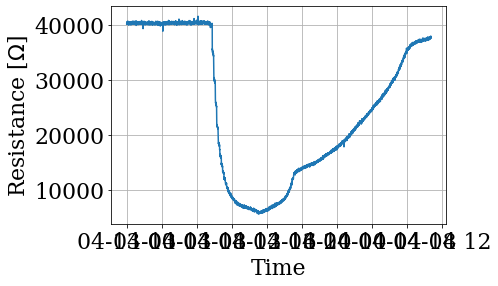

In [10]:
axR = plt.figure('resistance').gca()
axR.set_xlabel("Time")
axR.set_ylabel(r"Resistance [$\Omega$]")
axR.plot(time_data,Rval_data)

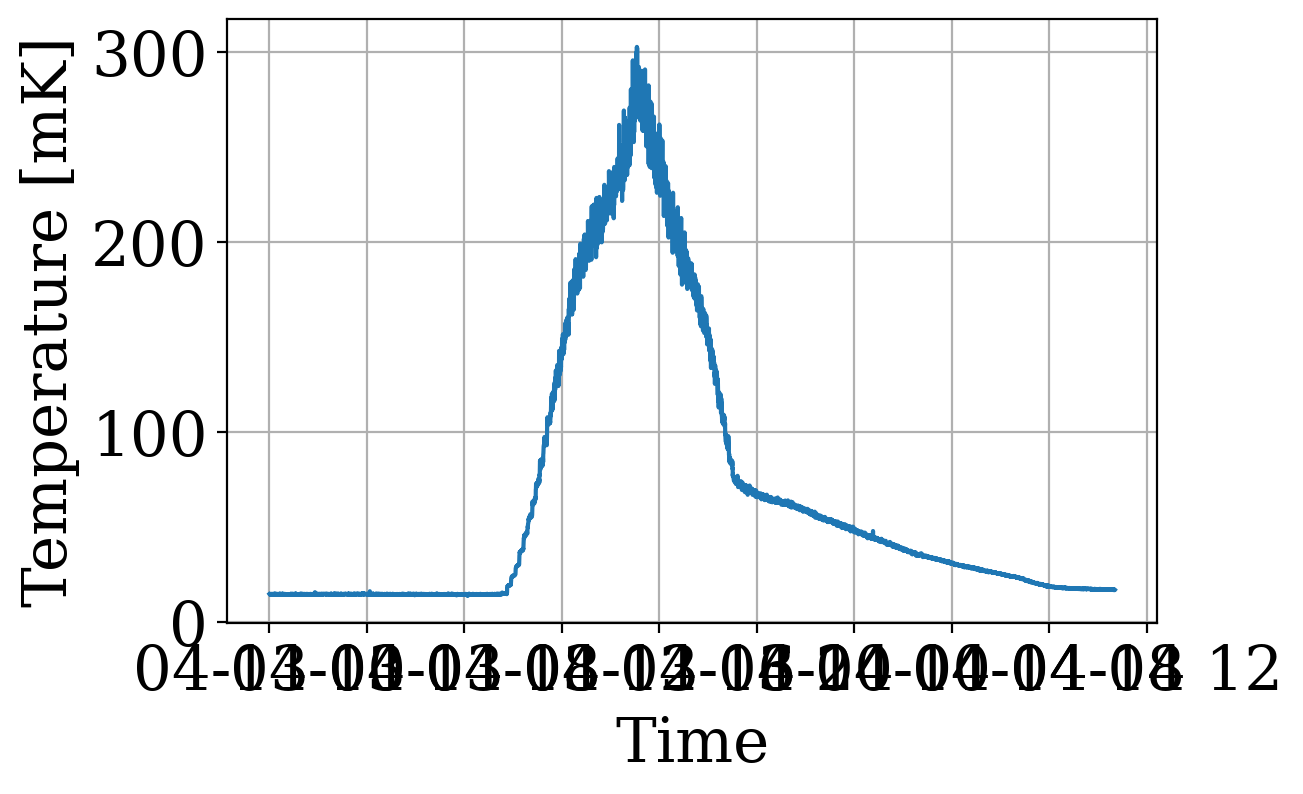

In [11]:
axT = plt.figure('temperature',dpi=200).gca()
axT.set_xlabel("Time")
axT.set_ylabel(r"Temperature [mK]")
axT.plot(time_data,TT2101_cal(Rval_data))

In [12]:
## Create an interpolator for the real resistance vs time data
ts_vals = np.array([time.mktime(dt.timetuple()) for dt in time_data]) 
resdata_time = interp1d(ts_vals, Rval_data)

## Load the PLC Temperature Data

In [13]:
import NEXUSFunctions as nf

In [14]:
Tscan_t0  = datetime.datetime(int(day_min[0:4] ),int(day_min[4:6] ),int(day_min[6:8] ),
                              int(time_min[0:2]),int(time_min[2:4]),int(time_min[4:6]))
days_span = 2
print(Tscan_t0)

2023-04-13 09:37:00


In [15]:
series_plc = nf.create_date_range(nf.dt_to_plc_str(Tscan_t0), days_span, fmt="%y%m%d")
offset_plc = datetime.timedelta(days=0, hours=0, minutes=0)
data_plc   = nf.read_plclog_data(series_plc, offset_plc)

series_mmr = nf.create_date_range(nf.dt_to_mmr_str(Tscan_t0), days_span)
offset_mmr = datetime.timedelta(days=0, hours=0, minutes=0)
data_mmr   = nf.read_MACRT_data(series_mmr, offset_mmr)

The starting date is: 
2023-04-13 00:00:00
The starting date is: 
2023-04-13 00:00:00


In [16]:
time_mmr = (data_mmr['ctime']-Tscan_t0).apply(nf.pd_td_to_days)
time_plc = (data_plc['ctime']-Tscan_t0).apply(nf.pd_td_to_days)

In [17]:
%matplotlib notebook

<IPython.core.display.Javascript object>


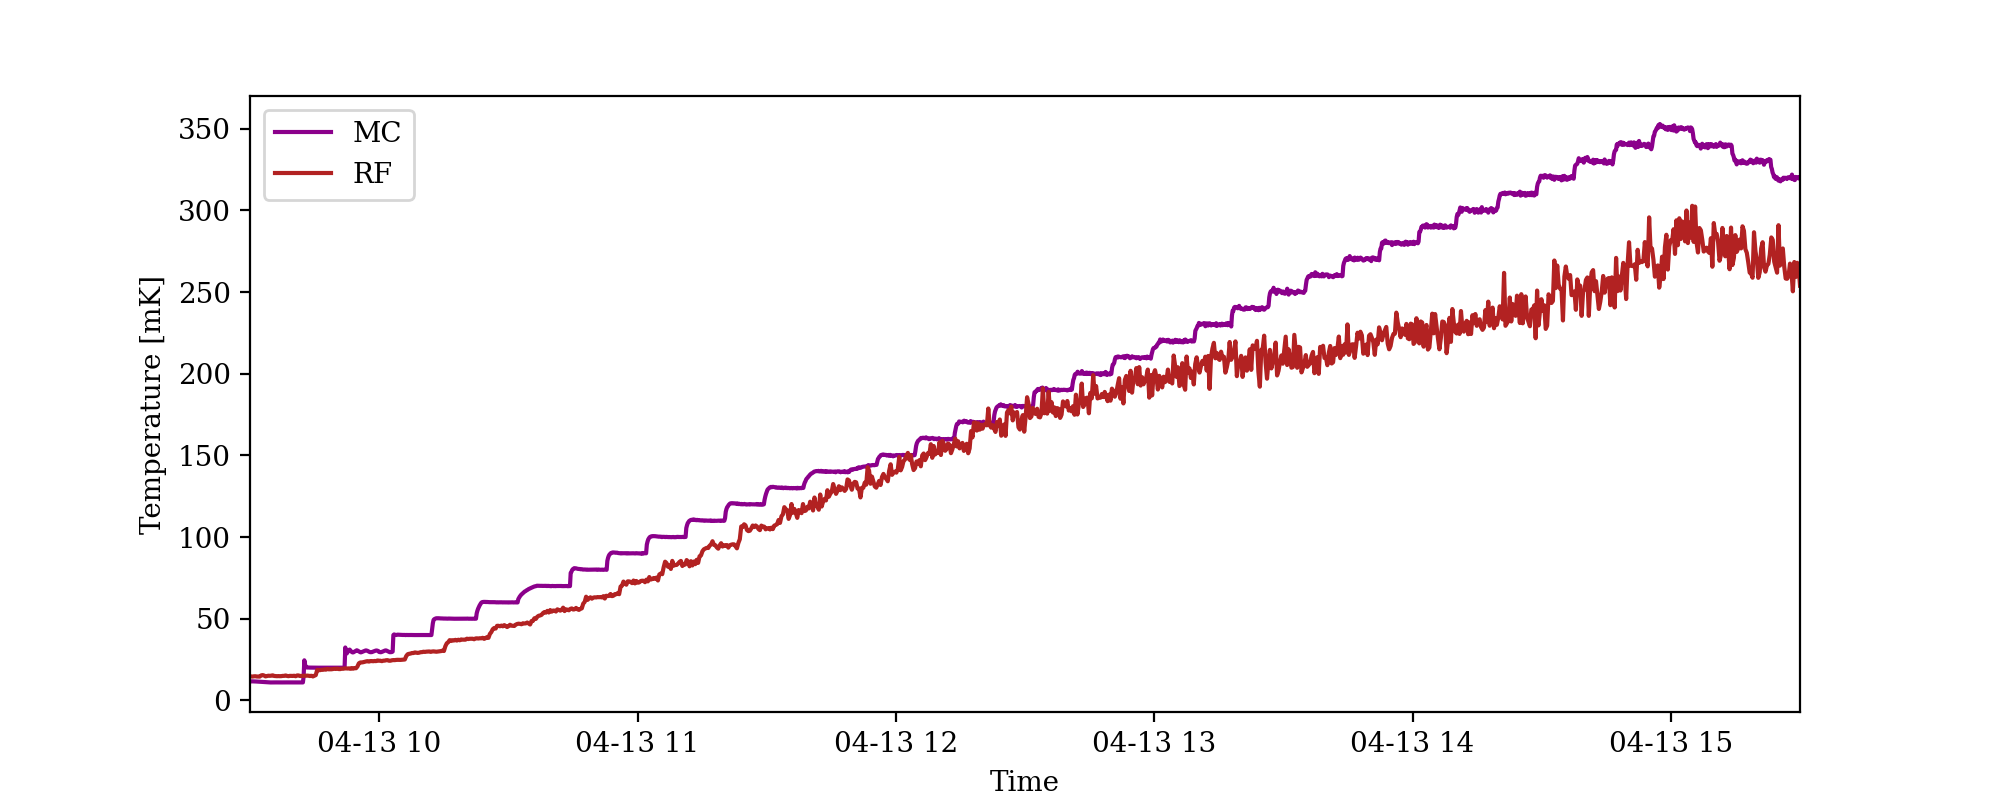

(19460.395833333332, 19460.645833333332)

In [24]:
f = plt.figure(figsize = (10,4))
a = plt.gca()
a.set_xlabel(r'Time')
a.set_ylabel('Temperature [mK]')

ls = "-"

c_RF = 'firebrick'
c_MC = 'darkmagenta'

a.plot(data_plc['ctime'],data_plc['FR MC']*1e3, label='MC', color=c_MC, ls=ls)
a.plot(time_data        ,TT2101_cal(Rval_data), label='RF', color=c_RF, ls=ls)

plt.grid()
plt.legend(loc="best")
# f.autofmt_xdate()
# myFmt = mdates.DateFormatter('%H:%M:%S')
# a.xaxis.set_major_formatter(myFmt)

# for T in np.arange(start=10.0, stop=350.0+10.0, step=10.0):
#     a.axhline(y=T, ls='--', c='k')
    
a.set_xlim([
    datetime.datetime(year=2023, month=4, day=13, hour= 9, minute=30, second=0, microsecond=0) , 
    datetime.datetime(year=2023, month=4, day=13, hour=15, minute=30, second=0, microsecond=0) , 
])

<IPython.core.display.Javascript object>


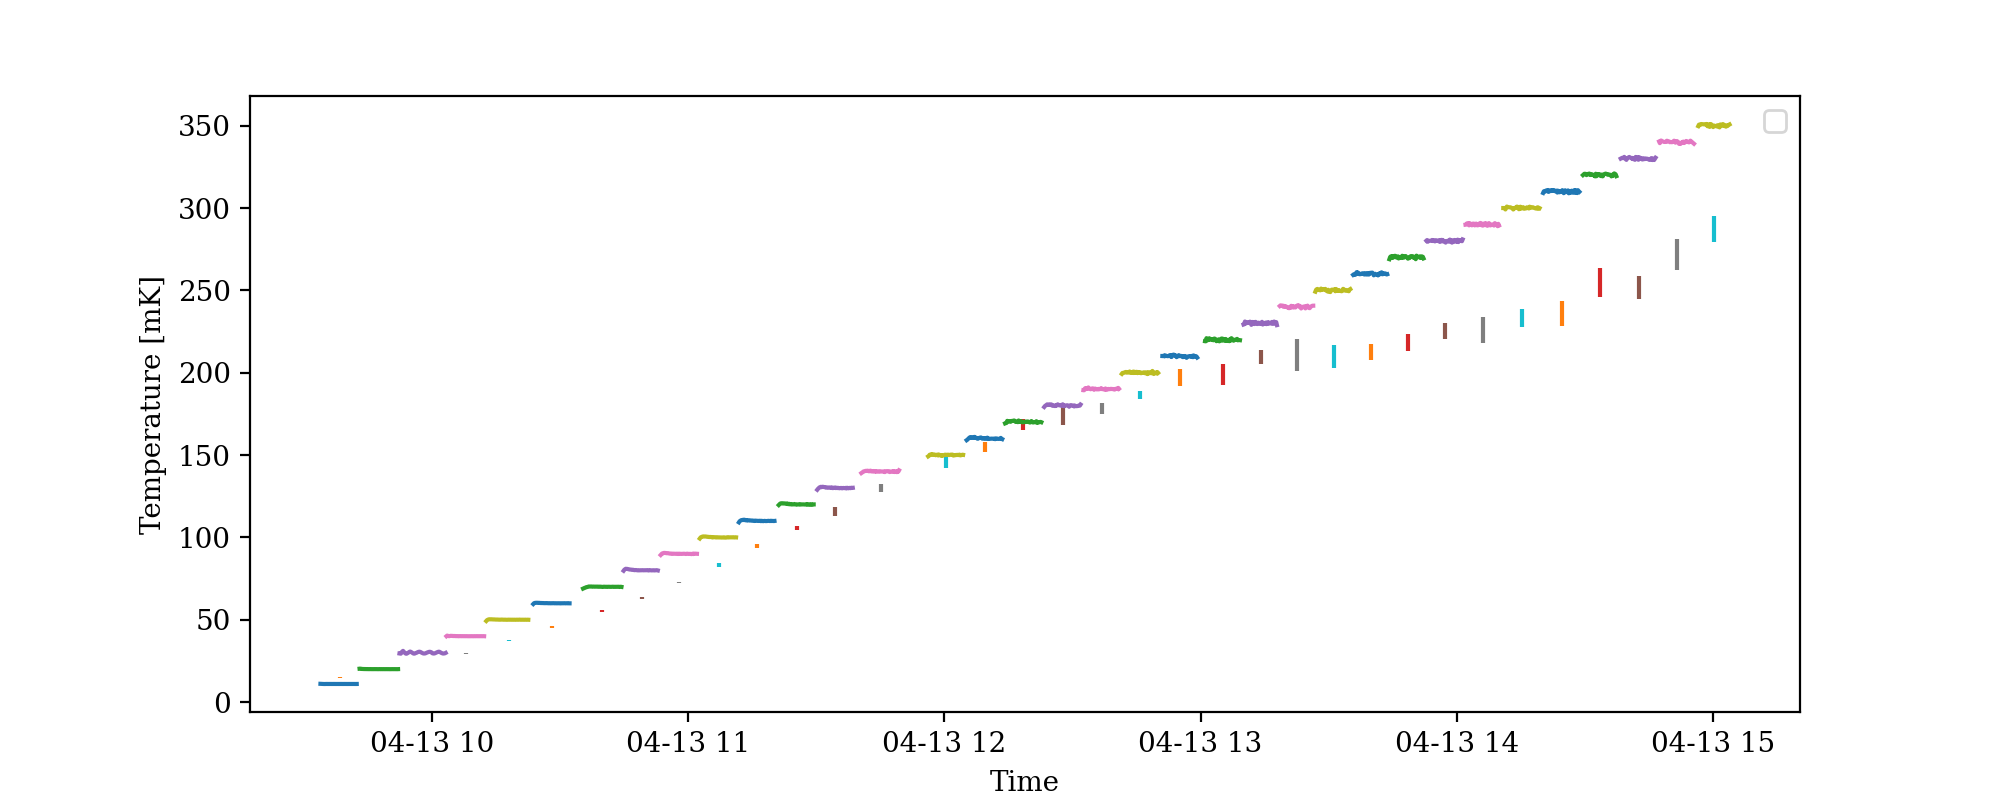

No handles with labels found to put in legend.


In [19]:
f = plt.figure(figsize = (10,4))
a = plt.gca()
a.set_xlabel(r'Time')
a.set_ylabel('Temperature [mK]')

ls = "-"

c_RF = 'firebrick'
c_MC = 'darkmagenta'

closeto = 1.1

t0 = datetime.datetime(year=2023, month=4, day=13, hour= 9, minute=30, second=0, microsecond=0)
t1 = datetime.datetime(year=2023, month=4, day=13, hour=15, minute= 4, second=0, microsecond=0)

T_map = {} # (key: T_mK, val: (mean,sdev) )}

for T in np.arange(start=10.0, stop=350.0+10.0, step=10.0):
#     a.axhline(y=T, ls='--', c='k')
    
    this_T_times = data_plc['ctime']
    this_T_vals  = data_plc['FR MC']*1e3
    
    this_T_vals  = this_T_vals[ this_T_times>t0]
    this_T_times = this_T_times[this_T_times>t0]
    
    this_T_vals  = this_T_vals[ this_T_times<t1]
    this_T_times = this_T_times[this_T_times<t1]
    
    close = np.abs(this_T_vals - T)
    
    this_T_vals  = this_T_vals[ close < closeto]
    this_T_times = this_T_times[close < closeto]
    
    a.plot(this_T_times,this_T_vals)
    
    TT_vals  = TT2101_cal(Rval_data)[ time_data>np.min(this_T_times)]
    TT_times = time_data[             time_data>np.min(this_T_times)]
    
    TT_vals  = TT_vals[ TT_times<np.max(this_T_times)]
    TT_times = TT_times[TT_times<np.max(this_T_times)]
    
#     a.plot(TT_times, TT_vals)
    
    if len(TT_times) < 1:
        continue
    
    N_half = int(len(TT_vals) / 2.)
    
    mean_time= TT_times[N_half]
    
    TT_vals  = TT_vals[ -N_half:]
    TT_times = TT_times[-N_half:]
    
    mean_TT  = np.mean(TT_vals)
    sdev_TT  = np.std(TT_vals)
    
    T_map[T] = (mean_TT,sdev_TT)
    
    a.errorbar(mean_time, mean_TT, yerr=sdev_TT)

# a.plot(data_plc['ctime'],data_plc['FR MC']*1e3, label='MC', color=c_MC, ls=ls)
# a.plot(time_data        ,TT2101_cal(Rval_data), label='RF', color=c_RF, ls=ls)

plt.grid()
plt.legend(loc="best")
# f.autofmt_xdate()
# myFmt = mdates.DateFormatter('%H:%M:%S')
# a.xaxis.set_major_formatter(myFmt)


    
# a.set_xlim([
#     datetime.datetime(year=2023, month=4, day=13, hour= 9, minute=30, second=0, microsecond=0) , 
#     datetime.datetime(year=2023, month=4, day=13, hour=15, minute=30, second=0, microsecond=0) , 
# ])

In [20]:
T_map

{10.0: (15.036062702390346, 0.14926509293648826),
 20.0: (19.24978487583918, 0.15583918672172858),
 30.0: (24.263946814481812, 0.20330956935966982),
 40.0: (29.51548486403726, 0.312307740143444),
 50.0: (37.43359582662582, 0.31888300078069104),
 60.0: (45.76435927594343, 0.48527797200994494),
 70.0: (55.22624857395994, 0.6206340902376026),
 80.0: (63.11136203740577, 0.4763425133009269),
 90.0: (72.61922433409829, 0.5834403154189844),
 100.0: (83.1515004236353, 1.3493262320738704),
 110.0: (94.83268590591702, 1.2043161958372801),
 120.0: (105.5288151316732, 1.2581285851703563),
 130.0: (115.54650870580171, 2.714614015006228),
 140.0: (130.11793045336432, 2.541302499596094),
 150.0: (146.06537610846337, 3.6282663060251745),
 160.0: (154.85391288593448, 2.792866782890353),
 170.0: (168.71955265024104, 3.30728361250838),
 180.0: (173.94475875964554, 5.814154948726291),
 190.0: (178.3888249799219, 3.210746248483032),
 200.0: (186.47217594048243, 2.4257789996019095),
 210.0: (196.92835791480

In [21]:
T_map_df = pd.DataFrame(T_map)

In [22]:
T_map_df

,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,...,260.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,340.0,350.0
0,15.036063,19.249785,24.263947,29.515485,37.433596,45.764359,55.226249,63.111362,72.619224,83.151500,...,212.489709,218.612401,225.602466,226.105417,233.194675,236.111936,254.751341,251.803027,271.783690,287.188695
1,0.149265,0.155839,0.203310,0.312308,0.318883,0.485278,0.620634,0.476343,0.583440,1.349326,...,5.004056,5.202163,4.875988,7.930031,5.344757,7.479394,8.825811,6.875958,9.114328,7.914008


In [23]:
T_map_df.to_hdf(os.path.join(dataPath,day_min+"_TempMap.h5"), 'map')